Используя базу данных автомобилей, создайте сеть с точностью распознавания не ниже 93% на проверочной выборке.

Для решения задачи вы можете использовать любой подход:
- модель без аугментации данных
- аугментация данных с помощью ImageDataGenerator
- аугментация данных с помощью самописного генератора изображений
- использовать готовую архитектуру из набора `tf.keras.applications` (Обратите внимание: на занятии мы не рассматривали данный модуль фреймворка Керас. Ваша задача: попробовать самостоятельно разобраться в приципах его работы. В разборе домашнего задания вы получите ссылку на ноутбук Базы Знаний УИИ, где подробно раскрывается вопрос использования готовых архитектур)

In [ ]:
# Ваше решение

In [1]:
import gdown
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if "middle_fmr.zip" in os.listdir():
    pass
else:
# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
    gdown.download(
        "https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip",
        None,
        quiet=True,
    )

In [3]:
if "cars" in os.listdir():
    pass
else:
    os.mkdir("cars")
    # Распаковка zip-архива с датасетом из облака на диск виртуальной машины colab
    !unzip -qo "middle_fmr.zip" -d cars/cars_train

In [4]:
TEST_SPLIT = VAL_SPLIT = 0.1
TRAIN_PATH = Path("cars/cars_train")
VAL_PATH = Path("cars/cars_val")
TEST_PATH = Path("cars/cars_test")

if not (TEST_PATH.exists() and VAL_PATH.exists()):
    TEST_PATH.mkdir(exist_ok=True)
    VAL_PATH.mkdir(exist_ok=True)

    for classfolder in TRAIN_PATH.iterdir():
        classfolder_test = TEST_PATH / classfolder.name
        classfolder_val = VAL_PATH / classfolder.name

        classfolder_test.mkdir(exist_ok=True)
        classfolder_val.mkdir(exist_ok=True)

        files = list(classfolder.iterdir())
        len_class = len(files)
        test_len = int(len_class * TEST_SPLIT)
        val_len = int(len_class * VAL_SPLIT)

        for i, img in enumerate(files):
            if i < test_len:
                img.rename(classfolder_test / img.name)
            elif i < test_len + val_len:
                img.rename(classfolder_val / img.name)
            else:
                break

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1.0 / 255.0,
)

test_and_val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
)

In [7]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 64

In [8]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

# Проверочная выборка генерируется из папки проверочного набора
validation_generator = test_and_val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_and_val_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 2745 images belonging to 3 classes.
Found 341 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


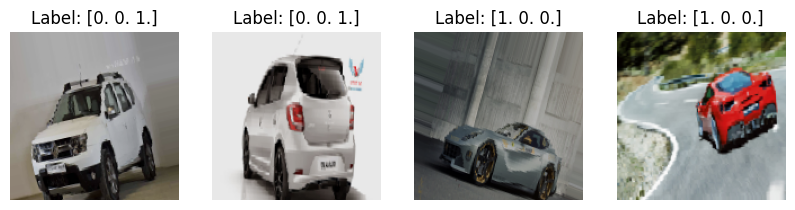

In [9]:
# Получаем один батч изображений и меток из генератора
images, labels = next(train_generator)

# Выводим первые несколько изображений из батча
num_images_to_show = 4
plt.figure(figsize=(10, 5))

for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

In [10]:
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    BatchNormalization,
    Input,
    Activation,
    GlobalAveragePooling2D,
    LeakyReLU,
)
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.applications import VGG19


In [11]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(
    weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

for layer in base_model.layers:
    layer.trainable = False


for layer in base_model.layers[-5:]:
    layer.trainable = True

model_vgg = Sequential(
    [
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.6),
        Dense(512, activation="relu"),
        Dropout(0.6),
        Dense(3, activation="softmax"),
    ]
)

model_vgg.compile(
    # optimizer=Adam(learning_rate=0.00001),
    optimizer=SGD(learning_rate=0.003, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
model_vgg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,288,579 (77.39 MB)

 Trainable params: 9,703,427 (37.02 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

In [13]:
history_vgg = model_vgg.fit(
    train_generator,
    epochs=150,
    validation_data=validation_generator,
    verbose=1,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 57s 963ms/step - accuracy: 0.3599 - loss: 1.2961 - val_accuracy: 0.5894 - val_loss: 0.9891
Epoch 2/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 556ms/step - accuracy: 0.5125 - loss: 0.9725 - val_accuracy: 0.7243 - val_loss: 0.7224
Epoch 3/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 557ms/step - accuracy: 0.6099 - loss: 0.8287 - val_accuracy: 0.7683 - val_loss: 0.6450
Epoch 4/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 555ms/step - accuracy: 0.6676 - loss: 0.7497 - val_accuracy: 0.8710 - val_loss: 0.4113
Epoch 5/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 560ms/step - accuracy: 0.7655 - loss: 0.6036 - val_accuracy: 0.7038 - val_loss: 0.6555
Epoch 6/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 559ms/step - accuracy: 0.7736 - loss: 0.5808 - val_accuracy: 0.8915 - val_loss: 0.3394
Epoch 7/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 557ms/step - accuracy: 0.8379 - loss: 0.4510 - val_accuracy: 0.8944 - val_loss: 0.2895
Epoch 8/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 560ms/step - accuracy: 0.8525 - loss: 0.3993 - 

In [16]:
print(
    f"Точность на обучающей выборке: {history_vgg.history['accuracy'][-1] * 100:.2f},\n"
    f"точность на проверочной выборке: {history_vgg.history['val_accuracy'][-1] * 100:.2f}"
)

Точность на обучающей выборке: 99.60,
точность на проверочной выборке: 93.26
